In [0]:
!pip install fastai2 -q

In [0]:
from fastai2.vision.all import *

In [103]:
source = untar_data(URLs.MNIST_TINY)
items = get_image_files(source)
fn = items[0]; fn

Path('/root/.fastai/data/mnist_tiny/train/7/8107.png')

# Transform

In [104]:
img = PILImage.create(fn); img

In [105]:
tconv = ToTensor()
img = tconv(img)
img.shape, type(img)

(torch.Size([3, 28, 28]), fastai2.torch_core.TensorImage)

In [106]:
img[:3, :3, :3]

tensor([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=torch.uint8)

In [107]:
lbl = parent_label(fn); lbl

'7'

In [108]:
tcat = Categorize(vocab=['3', '7'])
lbl = tcat(lbl); lbl

TensorCategory(1)

In [109]:
lbld = tcat.decode(lbl); lbld

'7'

# Pipeline

เราสามารถเอา Transform หลาย ๆ อัน มาต่อกัน ให้ทำงานตามลำดับ เหมือนด้านบน ด้วย Pipeline

In [110]:
pipe = Pipeline([PILImage.create, tconv])
img = pipe(img)

img.shape, type(img)

(torch.Size([3, 28, 28]), fastai2.torch_core.TensorImage)

สามารถสั่ง show ได้ด้วย Pipeline จะรู้เองว่าต้องแปลงกลับอย่างไร ให้เป็นรูปต้นฉบับ เพื่อการแสดงผลที่ถูกต้อง

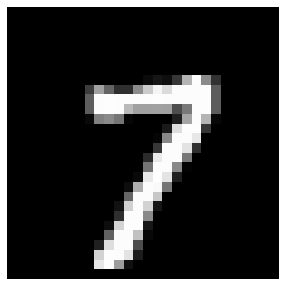

In [111]:
pipe.show(img, figsize=(5, 5), cmap='Greys');

# Creating custom Transform

เราจะมาลองสร้าง Transform ใช้เองกัน

ติดตั้ง albumentation ที่ใช้ในการทำ Data Augmentation รูปภาพ

In [0]:
! pip install albumentations -q

เราจะใช้ Pets Dataset ที่เป็นรูปสี ความละเอียดสูง จะได้เห็น Data Augmentation ชัดขึ้น กว่า ตัวเลขขาวดำ ภาพเล็ก ๆ

In [0]:
source = untar_data(URLs.PETS)
items = get_image_files(source/"images")

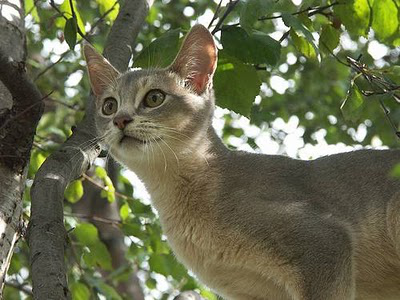

In [114]:
img = PILImage.create(items[0])
img

In [0]:
from albumentations import ShiftScaleRotate

In [0]:
aug = ShiftScaleRotate(p=1)

In [0]:
def aug_tfm(img):
    np_img = np.array(img)
    aug_img = aug(image=np_img)['image']
    return PILImage.create(aug_img)

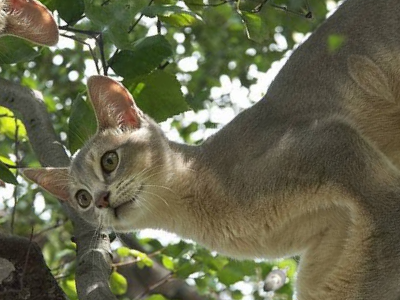

In [118]:
aug_tfm(img)

เราสามารถ สร้าง Transform ใหม่ ได้ด้วยการ pass function ให้ Transform โดยตรง

In [0]:
tfm = Transform(aug_tfm)

หรือสร้าง Class ขึ้นมาใหม่ โดยเราสามารถกำหนด Type ของ input ของ encodes ได้ ในเคสนี้ คือ PILImage ถ้าไม่ใช่ก็จะปล่อยผ่าน ไม่ทำงาน เราสามารถกำหนดได้หลาย Method รองรับหลาย Type เป็น Polymorphism

In [0]:
class AlbumentationsTransform(Transform):
    def __init__(self, aug): self.aug=aug
    def encodes(self, img:PILImage):
        aug_img = self.aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

ลองใช้งานดู

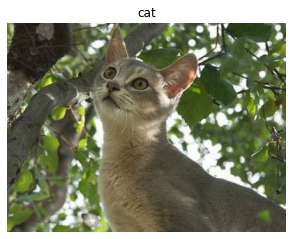

In [121]:
tfm = AlbumentationsTransform(ShiftScaleRotate(p=1))
a, b = tfm((img, 'cat'))
show_image(a, title=b);

# Transform whole tuple

แทนที่เราจะ Transform แยกกัน ระหว่าง Input และ Label เราสามารถกำหนดให้ Transform รับทั้งสองอย่างมาเป็น Tuple ได้เลย ด้วยการ inherit จาก ItemTransform

ในเคสนี้ เราจะใช้ Camvid Dataset จะได้เห็นภาพชัด เนื่องจากเป็นรูปเหมือนกัน ทั้ง Input และ Label แต่ต้องการ Transform ที่แตกต่างกัน คือ Image และ Mask

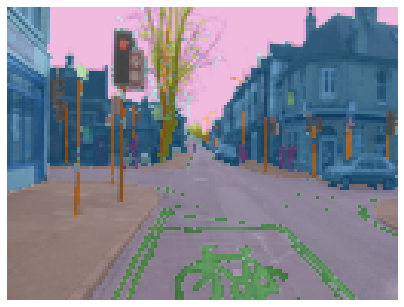

In [122]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_items = get_image_files(cv_source/"images")
img = PILImage.create(cv_items[0])
mask = PILMask.create(cv_source/'labels'/f'{cv_items[0].stem}_P{cv_items[0].suffix}')
ax = img.show(figsize=(7, 7))
ax = mask.show(ctx=ax)

เราจะสร้าง class ใหม่ ที่ subclass จาก ItemTransform ทำให้ encodes รับ x, y พร้อมกัน เป็น Tuple

In [0]:
class SegmentationAlbumentationsTransform(ItemTransform):
    def __init__(self, aug): self.aug=aug
    def encodes(self, x):
        img, mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug['image']), PILMask.create(aug['mask'])

ลองใช้ดู

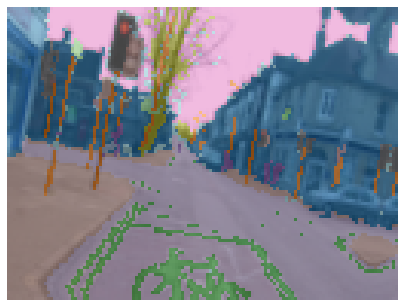

In [124]:
tfm = SegmentationAlbumentationsTransform(ShiftScaleRotate(p=1))
a, b = tfm((img, mask))
ax = a.show(figsize=(7, 7))
ax = b.show(ctx=ax)

We can reverse behavior by define decodes method and define setup to create some initial states.

เมื่อมี encodes เราก็ควรกำหนด decodes ในการแปลงกลับ เพื่อใช้ในการแสดงผล นอกจากนี้ใน subclass ItemTransform เรายังสามารถสร้าง setup method ในการกำหนดค่าเริ่มต้น

# Try use only Transform 

In [125]:
source = untar_data(URLs.PETS)/"images"
items = get_image_files(source)
len(items)

7390

make image same size and covert to tensor

In [0]:
def resized_image(fn:Path, sz=128):
    x = Image.open(fn).convert('RGB').resize((sz, sz))
    return tensor(array(x)).permute(2, 0, 1).float()/255.

define how TitledImage type show itself with show method.

In [0]:
class TitledImage(Tuple):
    def show(self, ctx=None, **kwargs): show_titled_image(self, ctx=ctx, **kwargs)

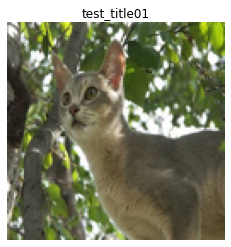

In [128]:
img = resized_image(items[0])
TitledImage(img, 'test_title01').show()

# Decodes to reverse process

ในการแสดงผล เราจำเป็นต้องใช้ decodes method ในการแปลง Tensor และ De-Normalize กลับเป็นรูปภาพต้นฉบับ และ แปลง CategoryTensor กลับเป็น Label ที่เราสามารถอ่านได้เข้าใจ

In [0]:
class PetTfm(Transform):
    def __init__(self, vocab, o2i, lblr): self.vocab, self.o2i, self.lblr = vocab, o2i, lblr
    def encodes(self, o): return [resized_image(o), self.o2i[self.lblr(o)]]
    def decodes(self, x): return TitledImage(x[0], self.vocab[x[1]])

* lblr = Labeler such as parent_labeler
* o2i = Object to Index / Label to Index
* vocab = Vocab Dictionary

In [0]:
labeller = using_attr(RegexLabeller(pat=r'^(.*)_\d+.jpg$'), 'name')

In [131]:
labeller(items[0]), items[0]

('Abyssinian',
 Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_79.jpg'))

In [0]:
vals = list(map(labeller, items))
vocab, o2i = uniqueify(vals, sort=True, bidir=True)

In [133]:
pets = PetTfm(vocab, o2i, labeller)
pets

PetTfm: (object,object) -> encodes (object,object) -> decodes

In [134]:
x, y = pets(items[0])
x.shape, y

(torch.Size([3, 128, 128]), 0)

ลอง decodes กลับ (สังเกตว่าใส่เป็น List ไม่ใช่ Tuple)

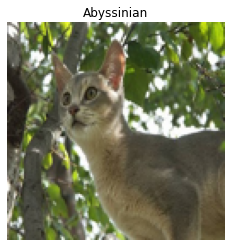

In [135]:
dec = pets.decode([x, y])
dec.show()

ให้ inherite จาก ItemTransform เพื่อรับข้อมูลเป็น Tuple

In [0]:
class PetTfm(ItemTransform):
    def __init__(self, vocab, o2i, lblr): self.vocab, self.o2i, self.lblr = vocab, o2i, lblr
    def encodes(self, o): return (resized_image(o), self.o2i(self.lblr(o)))
    def decodes(self, x): return TitledImage(x[0], self.vocab[x[1]])

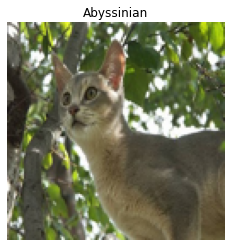

In [137]:
# items[0]
# pets(items[0])
dec = pets.decode(pets(items[0]))
dec.show()

# สร้าง Setups สำหรับ ItemTransform

ตัวอย่างเช่น เราจะยกโค้ดด้านบน ที่ใช้ในการกำหนดค่าเริ่มต้น ของ ItemTransform ไปไว้ใน setups

In [0]:
class PetTfm(ItemTransform):
    def setups(self, items):
        self.labeller = using_attr(RegexLabeller(pat=r'^(.*)_\d+.jpg$'), 'name')
        vals = map(self.labeller, items)
        self.vocab, self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): return (resized_image(o), self.o2i[self.labeller(o)])
    def decodes(self, x): return TitledImage(x[0], self.vocab[x[1]])

In [139]:
pets = PetTfm()
pets.setup(items)
x, y = pets(items[0])
x.shape, y

(torch.Size([3, 128, 128]), 0)

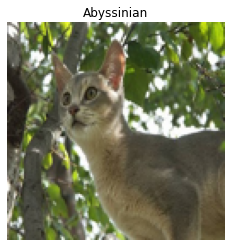

In [140]:
dec = pets.decode((x, y))
dec.show()

# ผสม Transform กับ Data Augmentation ด้วย Pipeline

เราจะเอา resize ออกจาก encodes ไปก่อน เหลือไว้แต่ เปิดรูปด้วย PILImate.create

In [0]:
# uniqueify??

In [0]:
class PetTfm(ItemTransform):
    def setups(self, items):
        self.labeller = using_attr(RegexLabeller(pat=r'^(.*)_\d+.jpg$'), 'name')
        vals = map(self.labeller, items)
        self.vocab, self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): return (PILImage.create(o), self.o2i[self.labeller(o)])
    def decodes(self, x): return TitledImage(x[0], self.vocab[x[1]])

เอา ItemTransform ด้านบน มาผสม Transform อื่น ๆ ต่อกันด้วย Pipeline

In [0]:
tfms = Pipeline([PetTfm(), Resize(224), FlipItem(p=1), ToTensor()])

เรียก setup ให้เตรียมข้อมูล สร้าง vocab List และ o2i Dictionary

In [0]:
tfms.setup(items)

In [145]:
tfms.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

เราสามารถเรียกใช้ Transform Pipeline ของเราได้ ดังนี้

In [146]:
x, y = tfms(items[0])
x.shape, y

(torch.Size([3, 224, 224]), 0)

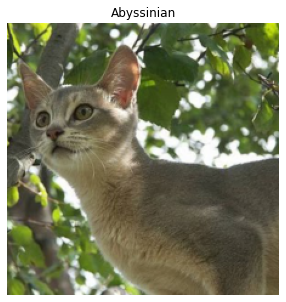

In [147]:
tfms.show((x, y))

เราสามารถดูลำดับในการ Transform ใน Pipeline ได้

In [148]:
tfms

Pipeline: PetTfm -> FlipItem -> Resize -> ToTensor

ลำดับของ Transform จะถูกกำหนดด้วย attribute ชื่อ order 

In [149]:
FlipItem.order, Resize.order, ToTensor.order, PetTfm.order

(0, 1, 5, 0)

ถ้าต้องการ เราสามารถกำหนด order ใน Transform ได้ เป็น Class Attribute

In [0]:
class PetTfm(ItemTransform):
    order = -5
    def setups(self, items):
        self.labeller = using_attr(RegexLabeller(pat=r'^(.*)_\d+.jpg$'), 'name')
        vals = map(self.labeller, items)
        self.vocab, self.o2i = uniqueify(vals, sort=True, bidir=True)

    def encodes(self, o): return (PILImage.create(o), self.o2i[self.labeller(o)])
    def decodes(self, x): return TitledImage(x[0], self.vocab[x[1]])

เราสามารถสร้าง Pipeline สลับลำดับมั่ว ๆ ได้เลย จะได้ Pipeline ตาม order อยู่ดี

In [151]:
tfms = Pipeline([Resize(224), PetTfm(), FlipItem(), ToTensor()])
tfms

Pipeline: PetTfm -> FlipItem -> Resize -> ToTensor

# TfmdLists

เราไม่จำเป็นต้องเรียก setup เอง Pipeline จะเรียก setup ด้วย items ให้โดยอัตโนมัติ

In [152]:
tls = TfmdLists(items, [Resize(224), PetTfm(), FlipItem(p=1.), ToTensor()])
x, y = tls[0]
x.shape, y

(torch.Size([3, 224, 224]), 0)

In [153]:
x[:3, :3, :3]

tensor([[[170, 175, 179],
         [174, 176, 181],
         [174, 178, 181]],

        [[204, 211, 213],
         [208, 212, 215],
         [206, 213, 214]],

        [[ 65,  49,  57],
         [ 71,  50,  56],
         [ 72,  53,  55]]], dtype=torch.uint8)

ทำให้เราได้ vocab เหมือนด้านบน

In [154]:
tls.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

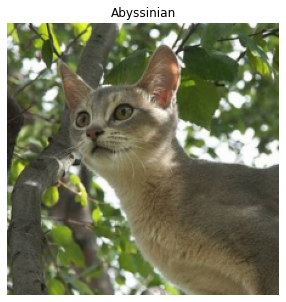

In [155]:
tls.show((x, y))

เราสามารถใช้ function ชื่อ show_at ในการแสดงผล

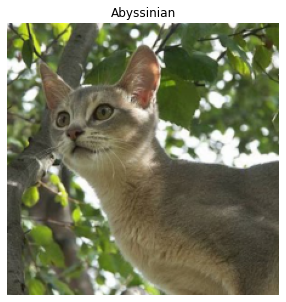

In [156]:
show_at(tls, 0)

# Split the Lists

TfmdLists รองรับหลาย List ใช้ในความหมาย คือ Training Set และ Validation Set โดยเราสามารถส่ง List ของ index ที่ใช้ในการแยกด้วย splits

In [157]:
splits = RandomSplitter(seed=42)(items)
splits

((#5912) [5643,5317,5806,3460,613,5456,2968,3741,10,4908...],
 (#1478) [4512,4290,5770,706,2200,4320,6450,501,1290,6435...])

In [0]:
tls = TfmdLists(items, [Resize(224), PetTfm(), FlipItem(p=0.5), ToTensor()], splits=splits)
# tls

In [0]:
# tls.train, tls.valid

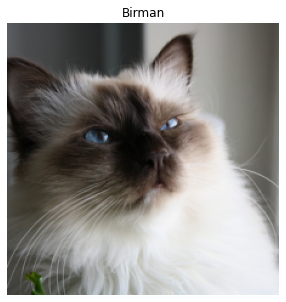

In [160]:
show_at(tls.train, 0)

# DataLoaders

In [0]:
dls = tls.dataloaders(bs=64)

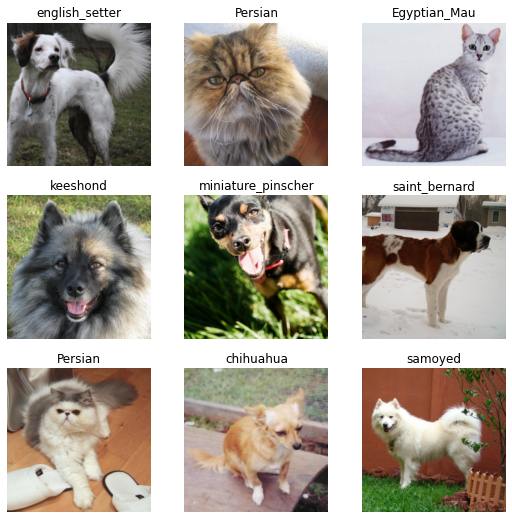

In [162]:
dls.show_batch()

เราสามารถเพิ่ม Data Augmentation ใน Batch Transform ได้โดย เพิ่มใน after_batch ด้วย IntToFloatTensor Transform ให้เป็น FloatTensor (เนื่องจาก Data Augmentation ของ fastai required FloatTensor) แล้วใส่ Data Augmentation Transform ที่ต้องการต่อ 

In [0]:
dls = tls.dataloaders(bs=64, after_batch=[IntToFloatTensor(), *aug_transforms()])

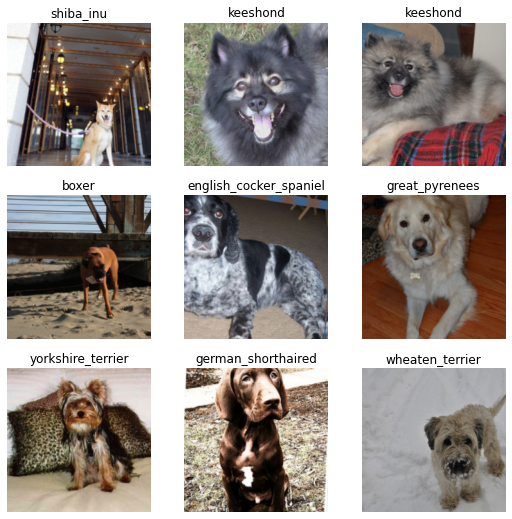

In [167]:
dls.show_batch()

# Datasets

Datasets คล้ายกับ TfmdLists แต่ถูกออกแบบมาให้รับข้อมูลเป็น List (เช่น 2 ข้อมูล คือ Training / Validation) และ List ของ List ของ Transform / Pipeline (2 List สำหรับหรับ 2 ชุดข้อมูล)

ในการสร้าง Transform เราสามารถกำหนด Type-Annotations ให้กับ method ที่จะทำงานเฉพาะเพื่อเจอกับ Type ที่กำหนดเท่านั้น ดังด้านล่าง

In [0]:
class ImageResizer(Transform):
    order=1

    def __init__(self, size, resample=Image.BILINEAR):
        if not is_listy(size): size=(size, size)
        self.size, self.resample = size, resample
    
    def encodes(self, o:PILImage): return o.resize(size=self.size, resample=self.resample)
    def encodes(self, o:PILMask): return o.resize(size=self.size, resample=Image.NEAREST)

ลองสร้าง Datasets ด้วยรายการ Transform ที่แตกต่างกัน สำหรับ Input และ Label

In [0]:
tfms = [[PILImage.create, ImageResizer(128), ToTensor(), IntToFloatTensor()], [labeller, Categorize()]]
dsets = Datasets(items, tfms)

ดูชนิดข้อมูล จาก Record แรก ของ Training Set

In [188]:
t = dsets.train[0]
# t = dsets[0]
type(t[0]), type(t[1])

(fastai2.torch_core.TensorImage, fastai2.torch_core.TensorCategory)

แปลงกลับเพื่อการแสดงผล

In [190]:
x, y = dsets.decode(t)
y, x.shape

('Abyssinian', torch.Size([3, 128, 128]))

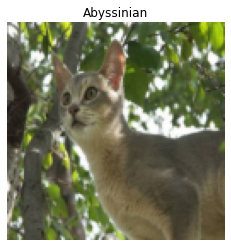

In [191]:
show_at(dsets.train, 0)

เราสามารถกำหนดได้ว่า จะ Split ข้อมูลอย่างไร เหมือนด้านบน ถ้าไม่กำหนด ก็จะ Default 

In [0]:
Datasets??

เราใส่ List ของ Transform ใน after_item ที่จะดำเนินการกับ Datasets ทั้งก้อน แต่ระบบก็จะรู้เองโดยอัตโนมัติว่า ต้องทำเฉพาะกับ Input ที่เป็นรูปภาพอย่างเดียว ไม่ต้องทำกับ Label ที่เป็น CategoryTensor

In [202]:
tfms = [[PILImage.create], [labeller, Categorize()]]
dsets = Datasets(items, tfms, splits=splits)
dls = dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])
dls

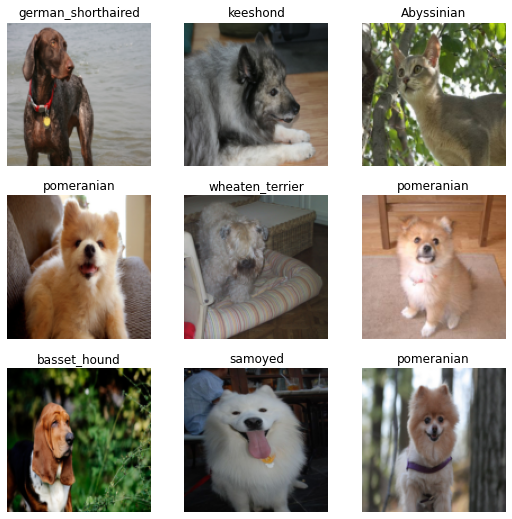

In [203]:
dls.show_batch()

เราสามารถใช้ TfmdDL ในการสร้าง DataLoaders อีกทางหนึ่ง

In [204]:
dsets = Datasets(items, tfms)
dls = TfmdDL(dsets, bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])
dls

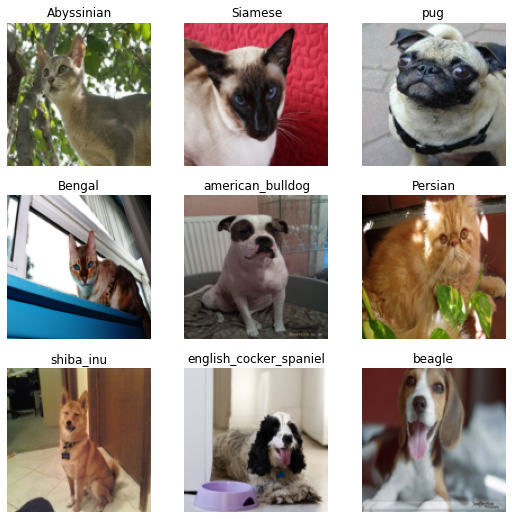

In [205]:
dls.show_batch()

# Segmentation

ในงาน Segmentation ที่จะ Label เป็น Image เหมือนกัน กับ Input แต่แตกต่างกัน ด้วยประเภทของรูป คือ PILImage และ PILMask 

Transform จะทำงานจาก Type-Annotations ที่เรากำหนดไว้ด้านบน

ดาวน์โหลด Dataset

In [206]:
cv_source = untar_data(URLs.CAMVID_TINY)
cv_source.ls()

(#3) [Path('/root/.fastai/data/camvid_tiny/codes.txt'),Path('/root/.fastai/data/camvid_tiny/images'),Path('/root/.fastai/data/camvid_tiny/labels')]

In [207]:
cv_items = get_image_files(cv_source/"images")
cv_items[:5]

(#5) [Path('/root/.fastai/data/camvid_tiny/images/Seq05VD_f02640.png'),Path('/root/.fastai/data/camvid_tiny/images/0016E5_05190.png'),Path('/root/.fastai/data/camvid_tiny/images/0016E5_08085.png'),Path('/root/.fastai/data/camvid_tiny/images/Seq05VD_f03960.png'),Path('/root/.fastai/data/camvid_tiny/images/Seq05VD_f01260.png')]

In [208]:
cv_splitter = RandomSplitter(seed=42)
cv_split = cv_splitter(cv_items)
cv_split

((#80) [89,86,18,40,5,38,9,82,83,43...],
 (#20) [42,96,62,98,46,95,60,24,78,16...])

In [0]:
cv_label = lambda o: cv_source/'labels'/f'{o.stem}_P{o.suffix}'

กำหนดรายการ Transform สร้าง Datasets / DataLoaders

In [212]:
tfms = [[PILImage.create], [cv_label, PILMask.create]]
cv_dsets = Datasets(cv_items, tfms, splits=cv_split)
dls = cv_dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])
dls

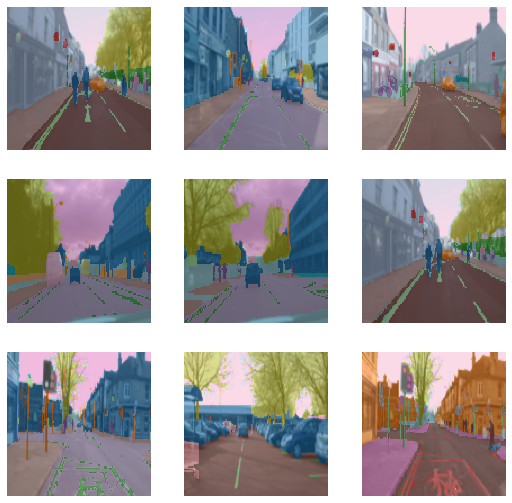

In [213]:
dls.show_batch()

ถ้าเราต้องการใช้ Data Augmentation class ที่สร้างไว้ด้านบน ให้ทำงานเฉพาะกับ Training Set เท่านั้น ไม่ต้องทำกับ Validation Set เราต้องกำหนด split_idx=0 ให้กับ class นั้น (0 = Training Set, 1 = Validation Set)

In [0]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx=0
    def __init__(self, aug): self.aug=aug
    def encodes(self, x):
        img, mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug['image']), PILMask.create(aug['mask'])

เรามาลองเรียกใช้ class ด้านบนดู

In [218]:
cv_dsets = Datasets(cv_items, tfms, splits=cv_split)
dls = cv_dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor(), SegmentationAlbumentationsTransform(ShiftScaleRotate(p=1))])
dls

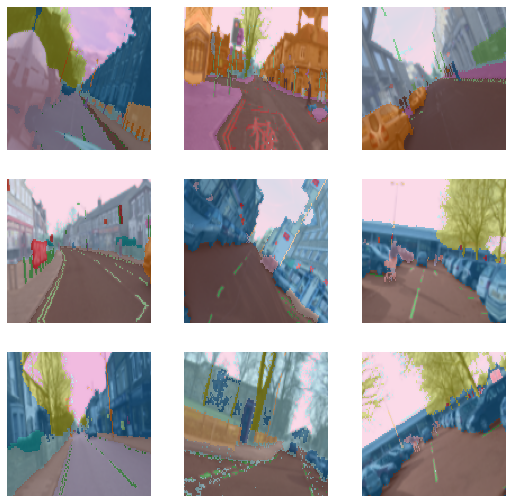

In [219]:
dls.show_batch()

# Test Set

นอกจาก Training Set และ Validation Set เราจะเพิ่ม Test Set เข้าไปใน DataLoaders ด้วย เพื่อใช้ในการ Inference

ย้อนกลับไปที่ Dataset เดิมคือ Pets

In [220]:
tfms = [[PILImage.create], [labeller, Categorize()]]
dsets = Datasets(items, tfms, splits=splits)
dls = dsets.dataloaders(bs=64, after_item=[ImageResizer(128), ToTensor(), IntToFloatTensor()])
dls

สมมติว่า มีข้อมูล Test Set อยู่ในอีก path 

In [222]:
path = untar_data(URLs.PETS)
tst_files = get_image_files(path/"images")
len(tst_files)

7390

เราจะสร้าง Test Set ด้วย test_dl

In [223]:
tst_dl = dls.test_dl(tst_files)
tst_dl

Test Set เอาไว้ Inference จะไม่มี Label 

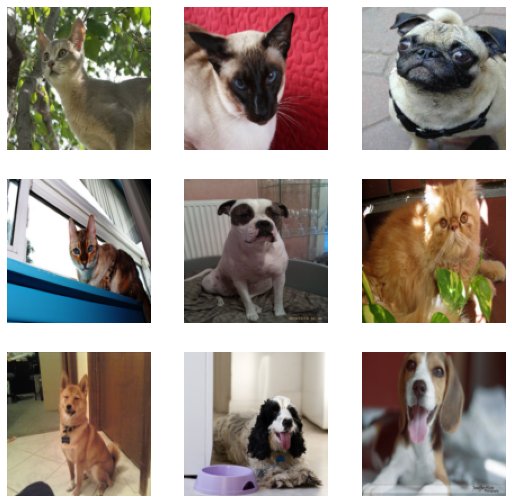

In [224]:
tst_dl.show_batch()

เราสามารถเรียก learn.get_preds แล้วใส่ข้อมูลเข้าไป เพื่อให้โมเดลของเราทำนายข้อมูลใน Test Set ได้

ในการเทรน เราสามารถสั่ง learn.export และ load_model สำหรับ Save และ Load โมเดล และ Transform / Pipeline ทั้งหมดขึ้นมาด้วยกัน